# Notes

Main results:
1. Cell type classification
    - Should scale this up by demonstrating across datasets/batches for a more notable result

2. Cell type marker calculation
    - Not super unique though. How can we leverage separate output-specific weights? (segue)

3. Hierarchical marker calculation
    - Opportunity for hierarchical understanding?

4. Dimension reduction
    - Reconstructs PC space (altho not surprising since it was trained on K-means from top PCs in the first place)
    - But also does so for the hierarchical case, which is much cooler

# Imports

In [ ]:
import scanpy as sc
import numpy as np
import plotly.express as px
import pandas as pd
import einops
import torch

from scripts.datasets import myeloid_classes
from scripts.bmlp import ScBMLPClassifier, Config

# Set params

In [10]:
d_hidden = 64
n_epochs = 100
lr = 1e-4

In [11]:
DEVICE = "cpu"  # faster than mps...

# Load data

In [12]:
adata, train_dataset, val_dataset, test_dataset = myeloid_dev_type(device=DEVICE, n_cell_types=3)

In [13]:
n_cells, n_genes = adata.shape
n_cell_types = adata.obs["cell_type"].nunique()

## Visualize

In [14]:
fig = px.scatter(
    x=adata.obsm["X_pca"][:, 0],
    y=adata.obsm["X_pca"][:, 1],
    color=adata.obs["cell_type"],
    title="Myeloid progenitor differentiation data",
    width=600,
    height=600,
)
fig.update_traces(marker=dict(size=5))
fig.show()

# Train model

In [15]:
cfg = Config(
    d_input=n_genes,
    d_hidden=d_hidden,
    d_output=n_cell_types,
    n_epochs=n_epochs,
    lr=lr,
    device=DEVICE,
)
model = ScBMLPClassifier(cfg)
train_losses, val_losses = model.fit(train_dataset, val_dataset)

Training for 100 epochs: 100%|██████████| 100/100 [00:09<00:00, 10.33it/s, train_acc=1.0000, train_loss=0.0001, val_acc=0.9193, val_loss=0.2326]


## Plot loss

In [16]:
# Combine train and val losses into a single plot
loss_df = pd.DataFrame({
    'Epoch': list(range(len(train_losses))) + list(range(len(val_losses))),
    'Loss': train_losses + val_losses,
    'Type': ['Train'] * len(train_losses) + ['Validation'] * len(val_losses)
})

px.line(loss_df, x='Epoch', y='Loss', color='Type', 
        title='Training and Validation Loss', 
        labels={'Loss': 'Loss', 'Epoch': 'Epoch'}).show()

# Interpret weights

## Investigate a particular $Q$ matrix (cell type)

In [9]:
cell_type = 0

In [10]:
q = einops.einsum(model.w_p[cell_type], model.w_l, model.w_r, "hid, hid in1, hid in2 -> in1 in2")
q = 0.5 * (q + q.mT)  # symmetrize

In [11]:
# px.imshow(
#     q,
#     color_continuous_scale='RdBu_r',
#     color_continuous_midpoint=0,
# )

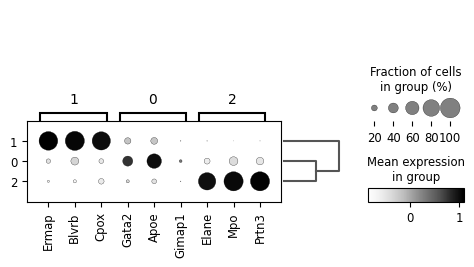

In [12]:
# Calculate gene markers for reference
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="logreg", n_genes=adata.shape[1])
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, cmap="Greys")

In [13]:
vals, vecs = torch.linalg.eigh(q)
vals = vals.flip([0])
vecs = vecs.flip([1])

In [14]:
px.histogram(vals.flatten(), nbins=100, title="Eigenvalues of $Q$").show()

In [15]:
n_top_genes = 10
for i in range(3):  # top components
    top_idxs = vecs[:,i].topk(n_top_genes).indices
    top_genes = adata.var_names[top_idxs].tolist()
    bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
    bottom_genes = adata.var_names[bottom_idxs].tolist()
    print("="*20, f"Component {i} ({vals[i]})", "="*20)
    print(top_genes)
    print(bottom_genes)

==================== Component 0 (0.07013331353664398) ====================
['Ly6c2', 'Ckap4', 'Phb2', 'Elane', 'Ssr2', 'Hsp90b1', 'Isyna1', 'Srp19', 'Hspa5', 'Beta-s']
['Apoe', 'Nrgn', 'Ptprcap', 'Mdga1', 'Gata2', 'Gnb2l1', 'Dapp1', 'Txnip', 'Cmtm4', 'Gpr56']
==================== Component 1 (0.027994103729724884) ====================
['Srp9', 'Tspo', 'Itm2b', 'Krtcap2', 'Hsd17b11', 'C1galt1c1', 'Pkn2', 'Plxnb2', 'Wasf2', 'Ccdc102a']
['Gatsl3', 'Dusp16', 'Dusp3', 'Dock8', 'Zfml', 'Fbxl20', 'Ttll9', 'Flt3', 'Usp25', 'Eif3m']
==================== Component 2 (0.026889201253652573) ====================
['Plekha2', 'Ulk3', 'Ptprs', 'Mrps28', 'Anp32a', 'BC025067', 'Map4k3', 'Nop2', 'Gp5', 'Heatr1']
['Syngr1', 'Ninl', 'Nxt1', 'Sh3bgrl3', 'Tapbpl', 'Itga2b', 'Arhgef3', 'Camsap1l1', 'Uhrf1bp1', 'Capn5']


In [16]:
# n_top_genes = 10
# for c in range(n_cell_types):
#     print(f"Cell type {c}")
#     for i in range(n_genes-1, n_genes-4, -1):  # top components
#         top_idxs = vecs[:,i].topk(n_top_genes).indices
#         top_genes = adata.var_names[top_idxs].tolist()
#         bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
#         bottom_genes = adata.var_names[bottom_idxs].tolist()
#         print("="*20, f"Component {i} ({vals[i]})", "="*20)
#         print(top_genes)
#         print(bottom_genes)
#     print()

Bottom components don't look that interesting.

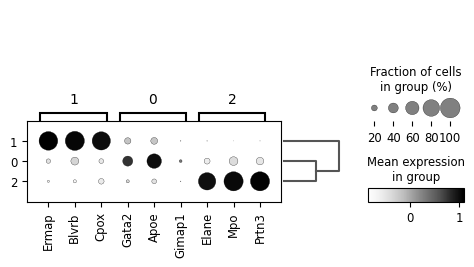

In [17]:
# Plot again for reference
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, cmap="Greys")

### Plot cells in $Q$ component space

In [18]:
adata.obsm["X_Q"] = adata.X @ vecs[:, :3].numpy()  # project into component space

fig = px.scatter(
    x=adata.obsm["X_Q"][:, 0],
    y=adata.obsm["X_Q"][:, 1],
    color=adata.obs["cell_type"],
    title="Myeloid progenitor differentiation data",
    width=600,
    height=600,
)
fig.update_traces(marker=dict(size=5))
fig.show()

NameError: name 'vecs' is not defined

# Iterate over output directions

In [19]:
b = einops.einsum(model.w_p, model.w_l, model.w_r, "out hid, hid in1, hid in2 -> out in1 in2")
b = 0.5 * (b + b.mT)  # symmetrize

## Print component markers

In [20]:
n_top_genes = 10
for c in range(n_cell_types):

    print(f"Cell type {c}")

    vals, vecs = torch.linalg.eigh(b[c])
    vals = vals.flip([0])
    vecs = vecs.flip([1])

    for i in range(3):  # top components
        top_idxs = vecs[:,i].topk(n_top_genes).indices
        top_genes = adata.var_names[top_idxs].tolist()
        bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
        bottom_genes = adata.var_names[bottom_idxs].tolist()
        print("="*20, f"Component {i} ({vals[i]})", "="*20)
        print(top_genes)
        print(bottom_genes)
    print()

Cell type 0
==================== Component 0 (0.12310803681612015) ====================
['Hpn', 'Rrm2', 'Erp29', 'Ppm1g', 'Snd1', 'Ctsg', 'Prtn3', 'Fam132a', 'Cpox', 'P4hb']
['Apoe', 'Serpina3f', 'S100a10', 'Ptprcap', 'Gata2', 'Ifitm1', 'Nrgn', 'Spns2', 'Txnip', 'Rps3']
==================== Component 1 (0.0324581153690815) ====================
['Rassf3', 'Grn', 'Pfkp', 'Sla', 'Acot7', 'Cdcrel-1', 'Pdlim2', 'Bambi', 'Tmem59', 'Ass1']
['Hba-a2', 'Ublcp1', 'Spna1', 'Lmna', 'Prelid2', 'Dkkl1', 'Hbb-b1', 'Uhrf1bp1', 'Sec14l2', 'Clec2d']
==================== Component 2 (0.028180202469229698) ====================
['Pf4', 'Gp9', 'Mnda', 'Mll2', 'AK081788', 'Cxcl10', 'Hp', 'Slc24a6', 'Olfm1', 'Rps6ka2']
['Tspan13', 'Plcl2', 'Elmo1', 'Txnl4a', 'Psmb2', 'Pccb', 'Cd63', 'Kit', 'Ctcf', 'Thrap3']

Cell type 1
==================== Component 0 (0.12310803681612015) ====================
['Hpn', 'Rrm2', 'Erp29', 'Ppm1g', 'Snd1', 'Ctsg', 'Prtn3', 'Fam132a', 'Cpox', 'P4hb']
['Apoe', 'Serpina3f', 'S100a10

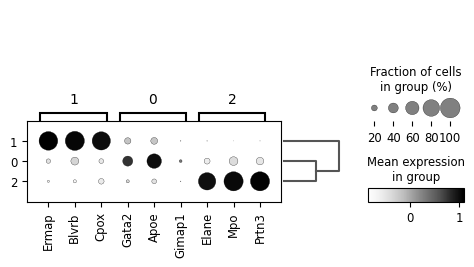

In [21]:
# Plot again for reference
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, cmap="Greys")

Wow. It actually works?

But marker genes are grouped on one side of a component.
- What does the other side mean?
- Explore analytically.

## Plot cells in component space

In [22]:
for c in range(n_cell_types):

    vals, vecs = torch.linalg.eigh(b[c])
    vals = vals.flip([0])
    vecs = vecs.flip([1])

    adata.obsm["X_Q"] = adata.X @ vecs[:, :3].numpy()  # project into component space

    fig = px.scatter(
        x=adata.obsm["X_Q"][:, 0],
        y=adata.obsm["X_Q"][:, 1],
        color=adata.obs["cell_type"],
        title=f"Cell type {c}",
        width=600,
        height=600,
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

Looks like the first component nicely separates the cells in the given type from the others.
- Cell type 0 components just happen to separate all three types radially quite nicely?

Could also just plot type histograms if only the top component is important.

In [23]:
for c in range(n_cell_types):

    vals, vecs = torch.linalg.eigh(b[c])
    vals = vals.flip([0])
    vecs = vecs.flip([1])

    adata.obsm["X_Q"] = adata.X @ vecs[:, :3].numpy()  # project into component space

    hist_df = pd.DataFrame({
        "component": adata.obsm["X_Q"][:, 0],
        "cell_type": adata.obs["cell_type"]
    })
    
    fig = px.histogram(
        hist_df,
        x="component",
        color="cell_type",
        title=f"Cell type {c} component histograms",
        opacity=0.7,
        nbins=30,
        barmode="overlay",
        width=600,
        height=300,
    )
    fig.show()

Nice, the pattern is clear in the histograms of just the top components.

What happens if we plot these cells in the space spanned by each cell type's top component?

In [24]:
top_vecs = []
for c in range(n_cell_types):
    _, vecs = torch.linalg.eigh(b[c])
    top_vecs.append(vecs[:,0])
top_vecs = torch.stack(top_vecs, dim=1)

adata.obsm["X_Q_tops"] = adata.X @ top_vecs.numpy()  # project into top component space

fig = px.scatter_3d(
    x=adata.obsm["X_Q_tops"][:, 0],
    y=adata.obsm["X_Q_tops"][:, 1],
    z=adata.obsm["X_Q_tops"][:, 2],
    color=adata.obs["cell_type"],
    title=f"Top component space",
    width=600,
    height=600,
)
fig.update_traces(marker=dict(size=5))
fig.show()

Reconstructs PC space. Could provide dimension reduction capability.

Could be trivial due to K-means' reliance on PCA.

# Phenotypic groups

In [21]:
output_dir = torch.tensor([0.,1.,1.])  # differentiated types
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")

In [22]:
vals, vecs = torch.linalg.eigh(q)
vals = vals.flip([0])
vecs = vecs.flip([1])

In [23]:
px.histogram(vals.flatten(), nbins=100, title="Eigenvalues of $Q$").show()

In [24]:
n_top_genes = 10
for i in range(3):  # top components
    top_idxs = vecs[:,i].topk(n_top_genes).indices
    top_genes = adata.var_names[top_idxs].tolist()
    bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
    bottom_genes = adata.var_names[bottom_idxs].tolist()
    print("="*20, f"Component {i} ({vals[i]})", "="*20)
    print(top_genes)
    print(bottom_genes)

==================== Component 0 (0.08466169983148575) ====================
['H2afy', 'Ly86', 'Pkm2', 'Irf8', 'Emb', 'Adssl1', 'Sdf2l1', 'Alas1', 'Mpo', 'Ctsg']
['Car2', 'Rhd', 'Hemgn', 'Pdlim1', 'Blvrb', 'Sphk1', 'Cpox', 'Crip2', '2210023G05Rik', 'Ccne1']
==================== Component 1 (0.04881025478243828) ====================
['Apoe', 'Ddah2', 'Gata2', 'Txnip', 'Dlg3', 'Mycn', 'Gimap1', '2210020M01Rik', 'Ehd3', 'HDAC7']
['Sh3pxd2b', 'Snrpd1', 'Cdk4', 'Hcfc1', 'P4hb', 'Ints8', 'Sod1', 'Psma7', 'Ppm1g', 'Tor3a']
==================== Component 2 (0.038345642387866974) ====================
['Tal1', 'Txn2', 'Neu1', 'Vat1', 'Rsu1', 'Mat2b', 'C530008M17Rik', 'Gstm4', 'Usp48', 'Lmcd1']
['Xdh', 'Lmnb2', 'Hk2', 'Arl11', 'Nfya', 'Tyrobp', 'D230014K01Rik', 'Crebbp', 'Csf2rb2', 'Sfrs7']


Not a good demonstration because `not(0)` = `(1,2)`, so really the markers for these two matrices should be the same?

## Check for consistency btwn complimentary directions

In [25]:
# Differentiated vs undifferentiated
output_dir = torch.tensor([0.,1.,1.])
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_diff = vecs[:,-1]

# Undifferentiated vs differentiated
output_dir = torch.tensor([1.,0.,0.])
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_undiff = vecs[:,-1]

### Gene space

In [26]:
px.scatter(
    x=genes_diff,
    y=genes_undiff,
    title="Differentiated vs Undifferentiated Components (genes)",
    labels={"x": "Differentiated Component", "y": "Undifferentiated Component"},
    hover_name=adata.var_names,
    width=600,
    height=600,
)

Looks like basically no correlation. Why?

Oh but it looks like a polytope:
- Differentiated component separates the two lineage branches.
- Undifferentiated components separates un/differentiated cells.

**So when we select a subset of the output directions, the component space describes how to distinguish between them.**

### Cell space

In [27]:
cells_diff = adata.X @ genes_diff.numpy()
cells_undiff = adata.X @ genes_undiff.numpy()

In [28]:
px.scatter(
    x=cells_diff,
    y=cells_undiff,
    color=adata.obs["cell_type"],
    title="Differentiated vs Undifferentiated Components (cells)",
    labels={"x": "Differentiated Component", "y": "Undifferentiated Component"},
    width=600,
    height=600,
)

Hm, so maybe the training labels are leaking PC info in here.
- Above result could be more trivial than I'd like.

# Contrastive directions

In [31]:
output_dir = torch.tensor([1.,0.,0.])
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_zero = vecs[:,-1]

output_dir = torch.tensor([1.,-1.,-1.])  # negate other directions
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_negative = vecs[:,-1]

In [32]:
px.scatter(
    x=genes_zero,
    y=genes_negative,
    title="Effect of negating outputs (genes)",
    labels={"x": "Without negating", "y": "With negating"},
    hover_name=adata.var_names,
    width=600,
    height=600,
)

In [35]:
cells_zero = adata.X @ genes_zero.numpy()
cells_negative = adata.X @ genes_negative.numpy()

In [36]:
px.scatter(
    x=cells_zero,
    y=cells_negative,
    color=adata.obs["cell_type"],
    title="Differentiated vs Undifferentiated Components (cells)",
    labels={"x": "Without negating", "y": "With negating"},
    width=600,
    height=600,
)

Cool, so negating the other directions doesn't rly do anything.
- Should be an analytical reason for this. Could it be exploited, or is it trivial?

# Next steps

1. Use expert-annotated cell types to reduce potential PCA bias.
2. Further explore dimension reduction capabilities.
    - Task is critical here; classification with few classes allowed this to occur.
3. Explore whether smooth changes in output space yield meaningful smooth changes in the gene network
    - Need to define what type of gene network is being represented. It's not a gene regulatory network, is it?
4. Apply this to a dataset focusing on healthy vs disease cells
    - This is the promise of interpretability, since the underlying biology in that case would be unknown.
    - In the case of myeloid dev here, we just did a validation by training on known biology (i.e. cell types).